In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 32

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.4, xtra_tfms=[*zoom_crop(scale=(0.75,1.5), do_rand=True)])
#tfms = get_transforms(flip_vert=True, max_lighting=0.4, xtra_tfms=[*zoom_crop(scale=(0.75,2), do_rand=True)])
#tfms = get_transforms(do_flip=True,flip_vert=True)
#get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0
#  , max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75
#  , p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None)

path = Path('train')
path.ls()
#dest = path/folder


[PosixPath('train/leaf_rust'),
 PosixPath('train/healthy_wheat'),
 PosixPath('train/stem_rust'),
 PosixPath('train/rename_jfif.sh'),
 PosixPath('train/export.pkl'),
 PosixPath('train/models')]

In [5]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.1, 
                                  ds_tfms=tfms, size=224,bs=bs, num_workers=8).normalize(imagenet_stats)

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['healthy_wheat', 'leaf_rust', 'stem_rust'], 3, 789, 87)

In [7]:
class Log_loss(Callback):

  def on_epoch_begin(self, **kwargs):
    self.count, self.val = 0., 0.

  def on_batch_end(self, last_output, last_target, **kwargs):
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0)
        loss = F.cross_entropy(last_output, *last_target)
        
        self.val += last_target[0].size(0) * loss.detach().cpu()

  def on_epoch_end(self, last_metrics, **kwargs):
    "Set the final result in `last_metrics`."
    return add_metrics(last_metrics, self.val/self.count)

In [8]:
learn = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy,Log_loss()]).mixup()

In [9]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

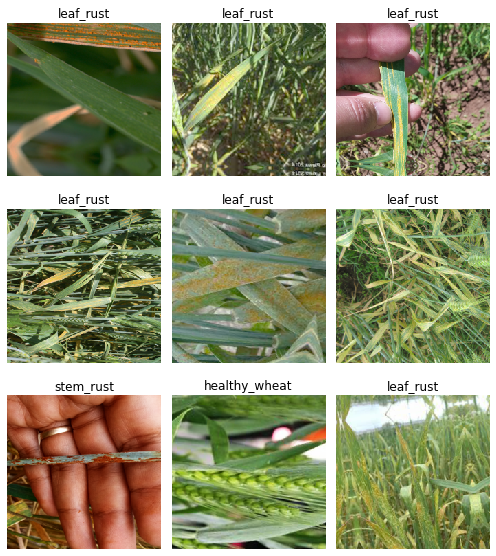

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 3.98E-03


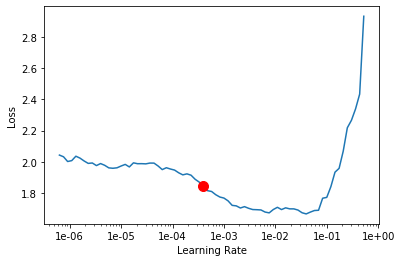

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(40, max_lr=slice(1e-3,1e-2))
learn.save('stage1a')

epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,1.606138,0.635945,0.229885,0.770115,0.635945,00:43
1,1.515086,0.542486,0.218391,0.781609,0.542486,00:38
2,1.351267,0.565607,0.195402,0.804598,0.565607,00:37
3,1.248129,0.520592,0.183908,0.816092,0.520592,00:37
4,1.112739,0.977995,0.241379,0.758621,0.977995,00:40
5,1.002972,0.456485,0.160920,0.839080,0.456485,00:38
6,0.923928,0.399999,0.149425,0.850575,0.399999,00:38
7,0.831778,0.587909,0.183908,0.816092,0.587909,00:39
8,0.814013,0.500934,0.218391,0.781609,0.500934,00:38
9,0.798475,0.438957,0.206897,0.793103,0.438957,00:38


In [14]:
#learn = learn.load("stage1b")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


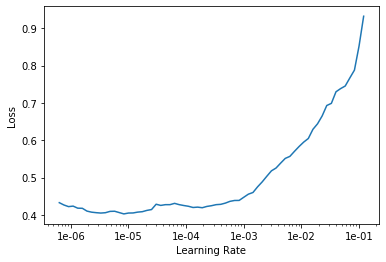

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))
learn.save('stage2a')

epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,0.460963,0.176837,0.045977,0.954023,0.176837,00:40
1,0.445067,0.178439,0.034483,0.965517,0.178439,00:37
2,0.449096,0.175477,0.057471,0.942529,0.175477,00:40
3,0.438619,0.180397,0.068966,0.931035,0.180397,00:41
4,0.438178,0.181354,0.057471,0.942529,0.181354,00:41
5,0.430888,0.182568,0.045977,0.954023,0.182568,00:42
6,0.435446,0.181242,0.045977,0.954023,0.181242,00:38
7,0.434599,0.185814,0.057471,0.942529,0.185814,00:40
8,0.429281,0.173713,0.057471,0.942529,0.173713,00:42
9,0.429939,0.178137,0.057471,0.942529,0.178137,00:37


In [17]:
learn.save('crop_fastai_M24f')
#learn = learn.load("crop_fastai_F11b")
learn.export()

In [18]:
path_test = Path('test')
path_test.ls()[0:5]

[PosixPath('test/K4KG21.jpg'),
 PosixPath('test/29QHAM.jpg'),
 PosixPath('test/DA6ERF.jpg'),
 PosixPath('test/2WZMHJ.jpg'),
 PosixPath('test/Z8067W.JPG')]

In [19]:
model_path = learn.path
inferernce_learn = load_learner(model_path, 'export.pkl', test=ImageList.from_folder('test'))
preds,y = inferernce_learn.get_preds(ds_type=DatasetType.Test)
preds[:5]

tensor([[9.7089e-01, 2.5735e-02, 3.3714e-03],
        [3.5562e-02, 2.6646e-01, 6.9798e-01],
        [1.9039e-02, 9.7410e-01, 6.8608e-03],
        [3.9556e-04, 9.9706e-01, 2.5414e-03],
        [5.9481e-03, 5.9453e-03, 9.8811e-01]])

In [20]:
inferernce_learn.data.test_dl.items

array([PosixPath('test/K4KG21.jpg'), PosixPath('test/29QHAM.jpg'), PosixPath('test/DA6ERF.jpg'),
       PosixPath('test/2WZMHJ.jpg'), ..., PosixPath('test/ENU2K6.jpg'), PosixPath('test/ERHSBV.jpg'),
       PosixPath('test/V4HYOA.jpg'), PosixPath('test/G9QN1Q.jpg')], dtype=object)

In [21]:
preds_clipped = preds.clamp(.001, .999)

In [22]:
test_df = pd.read_csv('sample_submission.csv')

In [23]:
inferernce_learn.data.classes

['healthy_wheat', 'leaf_rust', 'stem_rust']

In [24]:
test_df[inferernce_learn.data.classes] = preds_clipped
test_df.to_csv('fastai_submission.csv', index=False)
test_df.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,643083,0.025735,0.003371,0.970894
1,008FWT,0.266458,0.697981,0.035562
2,00AQXY,0.974100,0.006861,0.019039
3,01OJZX,0.997063,0.002541,0.001000
4,07OXKK,0.005945,0.988107,0.005948


In [25]:
import os
submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir('test')  if s.split('.')[1] != 'jfif']})

In [26]:
test_df['file_name'] = inferernce_learn.data.test_dl.items

In [27]:
test_df.to_csv('fastai_outM24f.csv', index=False)